Name1: Ahmed Mohamed Mostafa id:19106092
Name2: Abdelrahman Mohamed id:19105956
Name3: Abdelrahman Haggag id:19106963


In [1]:
import tensorflow as tf

# Set which GPU to use
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print('Using GPU:', gpus[0])
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


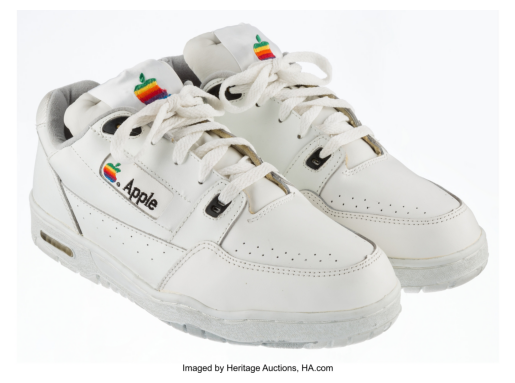

In [76]:
import matplotlib.pyplot as plt
from PIL import Image

# Path to the image file
image_path = "D:\\term 8\\Apple-sneakers.jpg"

# Load the image using PIL
image = Image.open(image_path)

# Display the image using matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()


In [2]:
import tensorflow as tf
import numpy as np 
import pandas as pd
from tensorflow import keras as ks
import keras 
from keras.models import Sequential

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
len(gpus)
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


In [54]:
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

def predict_image(models, img_path):
    predictions = []

    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_preprocessed = preprocess_input(np.expand_dims(img_array, axis=0))

    # Create a batch of images by repeating the same image
    img_batch = np.repeat(img_preprocessed, len(models), axis=0)

    # Make predictions for the batch of images
    batch_predictions = np.vstack([model.predict(img_batch) for model in models])

    # Decode predictions for each model
    for model_predictions in batch_predictions:
        decoded_predictions = decode_predictions(np.expand_dims(model_predictions, axis=0), top=1)[0]
        predicted_classes = [class_name for (_, class_name, _) in decoded_predictions]
        predicted_probabilities = [probability for (_, _, probability) in decoded_predictions]
        predictions.append(list(zip(predicted_classes, predicted_probabilities)))

    return predictions




In [36]:
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import os

def prepare_dataset(data_dir, target_size):
    # Resize images in the given directory
    resize_images(data_dir, target_size)
    
    datagen = ImageDataGenerator(
        rescale=1/255,
        rotation_range=40,
        width_shift_range=.2,
        height_shift_range=.2,
        shear_range=.1,
        horizontal_flip=True,
        fill_mode='nearest',
        zoom_range=.2,
    )
    generator = datagen.flow_from_directory(
        data_dir,
        target_size=target_size,
        class_mode='categorical',
        batch_size=128
    )
    return generator

def resize_images(directory, target_size):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(directory, filename)
            img = Image.open(image_path)
            resized_img = img.resize(target_size)
            resized_img.save(image_path)

train_iterator = prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Train", (225, 225))
validation_iterator = prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Valid", (225, 225))
test_iterator = prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Test", (225, 225))

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 1215 images belonging to 5 classes.


In [5]:
validation_iterator.class_indices

{'Ballet Flat': 0, 'Boat': 1, 'Brogue': 2, 'Clog': 3, 'Sneaker': 4}

In [6]:
#accuracy adjustment (dynamic learning rate per epoch,setting the learning rate to a specific value)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


def learning_rate_schedule(epoch):
    initial_learning_rate = 0.001
    decay_steps = 1000
    decay_rate = 0.1
    lr = initial_learning_rate * decay_rate ** (epoch // decay_steps)
    return lr

#learning rate
optimizer = Adam(learning_rate=0.001)


In [106]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import regularizers
from keras.callbacks import ReduceLROnPlateau                                                                                                                                                                                                                                                                                                                                                                                                           

# Initialising the CNN
classifier = Sequential()

# Convolution and Pooling layers
classifier.add(Conv2D(32, (3, 3), input_shape=(225, 225, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(256, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
classifier.add(Flatten())

# Fully connected layers with regularization and dropout
#classifier.add(Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#classifier.add(Dropout(0.5))  # Adding dropout for regularization

classifier.add(Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
classifier.add(Dropout(0.5))  # Adding dropout for regularization

classifier.add(Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
classifier.add(Dropout(0.5))  # Adding dropout for regularization


#classifier.add(Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#classifier.add(Dropout(0.5))  # Adding dropout for regularization
# Output layer
classifier.add(Dense(units=5, activation='softmax'))

# Compiling the CNN
classifier.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# Define the learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, verbose=1)
#to allow the model to choose it's best  
classifier.fit(train_iterator, epochs=20,validation_data=validation_iterator,steps_per_epoch=len(train_iterator),validation_steps=len(validation_iterator),callbacks=[reduce_lr])
#classifier.fit(train_iterator,epochs=20,validation_data=(validation_iterator),callbacks=[reduce_lr])


Epoch 1/20
79/79 [==============================] - 116s 1s/step - loss: 3.0774 - accuracy: 0.1908 - val_loss: 1.9939 - val_accuracy: 0.2000
Epoch 2/20
79/79 [==============================] - 107s 1s/step - loss: 1.8157 - accuracy: 0.2007 - val_loss: 1.7123 - val_accuracy: 0.2000
Epoch 3/20
79/79 [==============================] - 108s 1s/step - loss: 1.6676 - accuracy: 0.2367 - val_loss: 1.6586 - val_accuracy: 0.2352
Epoch 4/20
79/79 [==============================] - 108s 1s/step - loss: 1.6055 - accuracy: 0.2846 - val_loss: 1.6002 - val_accuracy: 0.2844
Epoch 5/20
79/79 [==============================] - 108s 1s/step - loss: 1.5521 - accuracy: 0.3054 - val_loss: 1.5343 - val_accuracy: 0.3144
Epoch 6/20
79/79 [==============================] - 108s 1s/step - loss: 1.5259 - accuracy: 0.3167 - val_loss: 1.4901 - val_accuracy: 0.2896
Epoch 7/20
79/79 [==============================] - 108s 1s/step - loss: 1.5170 - accuracy: 0.3223 - val_loss: 1.4999 - val_accuracy: 0.3308
Epoch 8/20
79

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#Initialising the CNN
classifier = Sequential()

#Convolution and Pooling layers
classifier.add(Conv2D(32, (3, 3), input_shape=(225, 225, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(256, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#Flattening
classifier.add(Flatten())

#Fully connected layers with regularization and dropout
classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.5))

#Output layer
classifier.add(Dense(units=5, activation='softmax'))

#Define the optimizer with adjusted learning rate
optimizer = Adam(learning_rate=0.001)

#Compiling the CNN
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Train the model
classifier.fit(train_iterator, epochs=30, validation_data=validation_iterator)


Epoch 1/30
79/79 [==============================] - 111s 1s/step - loss: 1.6171 - accuracy: 0.2152 - val_loss: 1.5977 - val_accuracy: 0.2592
Epoch 2/30
79/79 [==============================] - 110s 1s/step - loss: 1.5515 - accuracy: 0.2812 - val_loss: 1.5004 - val_accuracy: 0.3308
Epoch 3/30
79/79 [==============================] - 107s 1s/step - loss: 1.5000 - accuracy: 0.3068 - val_loss: 1.4393 - val_accuracy: 0.3556
Epoch 4/30
79/79 [==============================] - 109s 1s/step - loss: 1.4802 - accuracy: 0.3228 - val_loss: 1.5372 - val_accuracy: 0.3144
Epoch 5/30
79/79 [==============================] - 111s 1s/step - loss: 1.4653 - accuracy: 0.3340 - val_loss: 1.4208 - val_accuracy: 0.3756
Epoch 6/30
79/79 [==============================] - 110s 1s/step - loss: 1.4397 - accuracy: 0.3553 - val_loss: 1.4004 - val_accuracy: 0.3876
Epoch 7/30
79/79 [==============================] - 108s 1s/step - loss: 1.4251 - accuracy: 0.3616 - val_loss: 1.3922 - val_accuracy: 0.4252
Epoch 8/30
79

In [26]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

#Initialising the CNN
classifier = Sequential()

#Convolution and Pooling layers
classifier.add(Conv2D(32, (3, 3), input_shape=(225, 225, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(128, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Conv2D(256, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

#Flattening
classifier.add(Flatten())

#Fully connected layers with regularization and dropout
classifier.add(Dense(units=256, activation='relu'))
classifier.add(Dropout(0.5))

classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dropout(0.5))

#Output layer
classifier.add(Dense(units=5, activation='softmax'))

#Define the optimizer with adjusted learning rate
optimizer = Adam(learning_rate=0.001)

#Compiling the CNN
classifier.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

#Train the model
classifier.fit(train_iterator, epochs=20, validation_data=validation_iterator)

Epoch 1/20
79/79 [==============================] - 113s 1s/step - loss: 0.1594 - accuracy: 0.2462 - val_loss: 0.1551 - val_accuracy: 0.2900
Epoch 2/20
79/79 [==============================] - 107s 1s/step - loss: 0.1542 - accuracy: 0.2936 - val_loss: 0.1498 - val_accuracy: 0.3392
Epoch 3/20
79/79 [==============================] - 106s 1s/step - loss: 0.1509 - accuracy: 0.3246 - val_loss: 0.1462 - val_accuracy: 0.3560
Epoch 4/20
79/79 [==============================] - 108s 1s/step - loss: 0.1492 - accuracy: 0.3424 - val_loss: 0.1411 - val_accuracy: 0.4016
Epoch 5/20
79/79 [==============================] - 106s 1s/step - loss: 0.1460 - accuracy: 0.3689 - val_loss: 0.1407 - val_accuracy: 0.4120
Epoch 6/20
79/79 [==============================] - 110s 1s/step - loss: 0.1446 - accuracy: 0.3872 - val_loss: 0.1430 - val_accuracy: 0.3968
Epoch 7/20
79/79 [==============================] - 111s 1s/step - loss: 0.1433 - accuracy: 0.4032 - val_loss: 0.1335 - val_accuracy: 0.4816
Epoch 8/20
79

In [20]:
import numpy as np
from PIL import Image

# Retrieve the class labels from the train_iterator object
class_labels = train_iterator.class_indices
class_labels = list(class_labels.keys())

# Load and preprocess the input image
image_path = "D:\\term 8\\Apple-sneakers.jpg"
image = Image.open(image_path)
image = image.resize((225, 225))  # Resize the image to match the input shape of the model
image_array = np.array(image) / 255.0  # Normalize the image pixel values between 0 and 1
image_array = np.expand_dims(image_array, axis=0)  # Add a batch dimension

# Make predictions using the trained model
predictions = classifier.predict(image_array)
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_class_probabilities = np.max(predictions, axis=1)

# Display the predicted class and corresponding percentage for each class
for predicted_class_index, predicted_class_probability in zip(predicted_class_indices, predicted_class_probabilities):
    predicted_class = class_labels[predicted_class_index]
    percentage = predicted_class_probability * 100
    print(f"The input image belongs to class '{predicted_class}' with {percentage:.2f}% probability.")


1/1 [==============================] - 0s 220ms/step
The input image belongs to class 'Sneaker' with 81.25% probability.


In [21]:
#resize the data to fit efficient net and VGG

train_iterator= prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Train", (224, 224))
validation_iterater =  prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Valid",(224,224))
test_iterator= prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Test",(224,224))

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 1215 images belonging to 5 classes.


In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_iterator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

In [29]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# VGG model initialization without the input layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
optimizer = Adam(learning_rate=0.001)

# Freeze the bottom layers
for layer in base_model.layers[:-3]:  # Fine-tune the last 3 layers
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create the final model
modeli = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
modeli.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [30]:
#train the model
rr_scheduler = LearningRateScheduler(learning_rate_schedule)
modeli.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=30, validation_data=validation_iterator, callbacks=[rr_scheduler])

Epoch 1/30
79/79 [==============================] - 111s 1s/step - loss: 1.5305 - accuracy: 0.3231 - val_loss: 1.2291 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 2/30
79/79 [==============================] - 105s 1s/step - loss: 1.0607 - accuracy: 0.5953 - val_loss: 0.8755 - val_accuracy: 0.6728 - lr: 0.0010
Epoch 3/30
79/79 [==============================] - 104s 1s/step - loss: 0.8300 - accuracy: 0.7003 - val_loss: 0.7690 - val_accuracy: 0.7244 - lr: 0.0010
Epoch 4/30
79/79 [==============================] - 105s 1s/step - loss: 0.7362 - accuracy: 0.7298 - val_loss: 0.7250 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 5/30
79/79 [==============================] - 105s 1s/step - loss: 0.6871 - accuracy: 0.7542 - val_loss: 0.7009 - val_accuracy: 0.7504 - lr: 0.0010
Epoch 6/30
79/79 [==============================] - 106s 1s/step - loss: 0.6254 - accuracy: 0.7779 - val_loss: 0.6349 - val_accuracy: 0.7680 - lr: 0.0010
Epoch 7/30
79/79 [==============================] - 105s 1s/step - loss: 0.5

In [103]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# VGG model initialization without the input layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
optimizer = Adam(learning_rate=0.01)

# Freeze the bottom layers
for layer in base_model.layers[:-3]:  # Fine-tune the last 3 layers
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

predictions = Dense(5, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])




rr_scheduler = LearningRateScheduler(learning_rate_schedule)
model.fit(train_iterator, steps_per_epoch=len(train_iterator), epochs=30, validation_data=validation_iterator, callbacks=[rr_scheduler])

Epoch 1/30
79/79 [==============================] - 165s 2s/step - loss: 1.3713 - accuracy: 0.4078 - val_loss: 0.9692 - val_accuracy: 0.6272 - lr: 0.0010
Epoch 2/30
79/79 [==============================] - 111s 1s/step - loss: 0.9112 - accuracy: 0.6609 - val_loss: 0.8953 - val_accuracy: 0.6668 - lr: 0.0010
Epoch 3/30
79/79 [==============================] - 116s 1s/step - loss: 0.7237 - accuracy: 0.7399 - val_loss: 0.7027 - val_accuracy: 0.7472 - lr: 0.0010
Epoch 4/30
79/79 [==============================] - 113s 1s/step - loss: 0.6603 - accuracy: 0.7654 - val_loss: 0.6625 - val_accuracy: 0.7612 - lr: 0.0010
Epoch 5/30
79/79 [==============================] - 111s 1s/step - loss: 0.5953 - accuracy: 0.7897 - val_loss: 0.6955 - val_accuracy: 0.7480 - lr: 0.0010
Epoch 6/30
79/79 [==============================] - 111s 1s/step - loss: 0.5859 - accuracy: 0.7948 - val_loss: 0.6105 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 7/30
79/79 [==============================] - 110s 1s/step - loss: 0.5

In [31]:
# Evaluate the model on test data
test_loss, test_accuracy = modeli.evaluate(test_iterator)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

10/10 [==============================] - 20s 2s/step - loss: 0.6831 - accuracy: 0.7761
Test Loss: 0.6831066608428955
Test Accuracy: 0.7761316895484924


In [64]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Get the class labels from the train iterator
class_labels = train_iterator.class_indices
class_labels = dict((v, k) for k, v in class_labels.items())

img_path = "D:\\term 8\\Apple-sneakers.jpg"  
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make a prediction
prediction = modeli.predict(x)
predicted_class = np.argmax(prediction[0])

# Get the predicted class label
class_label = class_labels[predicted_class]

print("Predicted class label:", class_label)


1/1 [==============================] - 0s 25ms/step
Predicted class label: Sneaker


In [32]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Preprocessing layer
preprocess_input = tf.keras.applications.resnet50.preprocess_input

# Unfreeze some layers
unfreeze_layers = 100  # Number of layers to unfreeze from the end

for layer in base_model.layers[:-unfreeze_layers]:
    layer.trainable = False

# Add custom output layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)


predictions = Dense(5, activation='softmax')(x)  # Adjust the number of output classes

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
#history = model.fit(train_iterator, epochs=10, validation_data=validation_iterator)


In [33]:
steps_per_epoch = train_iterator.samples // train_iterator.batch_size


# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(learning_rate_schedule)

# Train the model in batches
model.fit(train_iterator, steps_per_epoch=steps_per_epoch, epochs=30, validation_data=validation_iterator, callbacks=[lr_scheduler])

Epoch 1/30
78/78 [==============================] - 118s 1s/step - loss: 1.6504 - accuracy: 0.2012 - val_loss: 1.6093 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/30
78/78 [==============================] - 109s 1s/step - loss: 1.6095 - accuracy: 0.2010 - val_loss: 1.6094 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
78/78 [==============================] - 109s 1s/step - loss: 1.6095 - accuracy: 0.1969 - val_loss: 1.6094 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 4/30
78/78 [==============================] - 110s 1s/step - loss: 1.6095 - accuracy: 0.1949 - val_loss: 1.6093 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 5/30
78/78 [==============================] - 110s 1s/step - loss: 1.6094 - accuracy: 0.1934 - val_loss: 1.6094 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 6/30
78/78 [==============================] - 109s 1s/step - loss: 1.6094 - accuracy: 0.1951 - val_loss: 1.6094 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 7/30
78/78 [==============================] - 111s 1s/step - loss: 1.6

In [65]:
train_iterator= prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Train", (225, 225))
validation_iterater =  prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Valid",(225,225))
test_iterator= prepare_dataset("D:\\term 8\\archive\\Shoes Dataset\\Test",(225,225))

Found 10000 images belonging to 5 classes.
Found 2500 images belonging to 5 classes.
Found 1215 images belonging to 5 classes.


In [73]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# CNN backbone
input_shape = (225, 225, 3)

# Convolutional layers
inputs = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)

# Classification head
dense = Dense(128, activation='relu')(x)
output = Dense(5, activation='softmax', name='classification')(dense)

# Create the model
model = Model(inputs=inputs, outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_iterator, epochs=30, validation_data=validation_iterator)

Epoch 1/30
79/79 [==============================] - 110s 1s/step - loss: 1.5641 - accuracy: 0.2777 - val_loss: 1.5367 - val_accuracy: 0.3192
Epoch 2/30
79/79 [==============================] - 111s 1s/step - loss: 1.4694 - accuracy: 0.3483 - val_loss: 1.3916 - val_accuracy: 0.4040
Epoch 3/30
79/79 [==============================] - 112s 1s/step - loss: 1.4046 - accuracy: 0.3979 - val_loss: 1.3460 - val_accuracy: 0.4348
Epoch 4/30
79/79 [==============================] - 117s 1s/step - loss: 1.3379 - accuracy: 0.4413 - val_loss: 1.2964 - val_accuracy: 0.4772
Epoch 5/30
79/79 [==============================] - 111s 1s/step - loss: 1.3064 - accuracy: 0.4676 - val_loss: 1.2701 - val_accuracy: 0.4940
Epoch 6/30
79/79 [==============================] - 107s 1s/step - loss: 1.2798 - accuracy: 0.4814 - val_loss: 1.2164 - val_accuracy: 0.5420
Epoch 7/30
79/79 [==============================] - 106s 1s/step - loss: 1.2352 - accuracy: 0.5108 - val_loss: 1.1563 - val_accuracy: 0.5568
Epoch 8/30
79

In [74]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# Get the class labels from the train iterator
class_labels = train_iterator.class_indices
class_labels = dict((v, k) for k, v in class_labels.items())

img_path = "D:\\term 8\\Apple-sneakers.jpg"  # Path to your image
img = image.load_img(img_path, target_size=(225, 225))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make a prediction
prediction = model.predict(x)
predicted_class = np.argmax(prediction[0])

# Get the predicted class label
class_label = class_labels[predicted_class]

print("Predicted class label:", class_label)


1/1 [==============================] - 0s 190ms/step
Predicted class label: Sneaker
